# CIFAR10 Dataset Compression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Outils.dataloader import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline

import os 
import glob

import cv2

## Data Loading

In [2]:
from Outils.dataloader import load_CIFAR10

# Load the raw CIFAR-10 data.
cifar10_dir = 'Dataset/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

X = np.concatenate([X_train, X_test])
X.shape

(60000, 32, 32, 3)

## Nearest Neighbors

In [3]:
from sklearn.neighbors import NearestNeighbors

In [4]:
n_images = 60000

In [5]:
X_fatten = X.reshape((n_images, -1))

In [6]:
NN = NearestNeighbors(n_neighbors = 2, n_jobs = -1, p = 2)
NN.fit(X_fatten)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=-1, n_neighbors=2, p=2, radius=1.0)

In [7]:
NN.kneighbors(X_fatten[0:10,], n_neighbors = 2, return_distance = False)[:,1]

array([48216, 10024, 58400, 57539, 58690, 11582, 24734, 47983, 34567,
       22515], dtype=int64)

In [8]:
y = NN.kneighbors(X_fatten[45702:45703,], n_neighbors = 2, return_distance = False)
y

array([[45702, 35877]], dtype=int64)

In [9]:
y[0][1]

35877

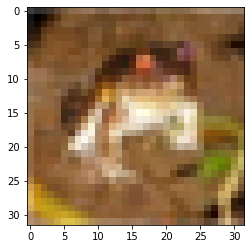

In [10]:
plt.imshow(X[0].astype('uint8'))

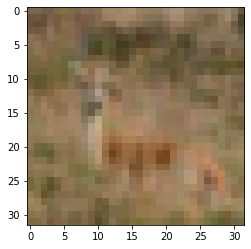

In [11]:
plt.imshow(X[48216].astype('uint8'))

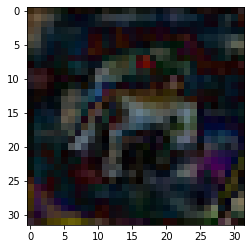

In [12]:
plt.imshow(np.abs(X[0] - X[48216]).astype('uint8'))

In [13]:
cv2.imwrite("org_cf.png", X[0])
cv2.imwrite("diff_abs_cf.png", np.abs(X[0] - X[48216]))

True

### Apply Nearest Neighbor to all data points

In [49]:
path_nn = "./Dataset/Compressed/nearest_neighbors_png/"

In [55]:
# for k in range(n_images):
#     id_k = NN.kneighbors(X_fatten[k:k+1,], n_neighbors = 2, return_distance = False)[0][1]
#     cv2.imwrite(path_nn + str(k) + ".png", np.abs(X[k] - X[id_k]))

#### Get the size of the compressed images

In [56]:
size = 0

for f in glob.glob(path_nn + "*.png"):
    size = size + os.path.getsize(f)

print(size)
np.save("./Saved_datas/nearest_neighbors__png_size.npy", size)

150023991


## Nearest Neighbors and Delta

Due to computationnal performance, we we just use 5000 images for experimental purpose

In [14]:
n_test = 5000
id_test = np.random.choice(range(n_images), n_test)

In [17]:
X_test = X[id_test,:,:,:]
X_fatten_test = X_fatten[id_test,:]

In [19]:
NN = NearestNeighbors(n_neighbors = 2, n_jobs = -1, p = 2)
NN.fit(X_fatten_test)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=-1, n_neighbors=2, p=2, radius=1.0)

In [20]:
idx = NN.kneighbors(X_fatten_test, n_neighbors = 2, return_distance = False)[:,1]

Save with PNG

In [21]:
path = "./Dataset/Test/png/"

for k in range(n_test):
    cv2.imwrite(path + str(k) + ".png",X_test[k])
    

Get size of PNG

In [22]:
size = 0
for f in glob.glob(path + "*.png"):
    size = size + os.path.getsize(f)

print(size)

12388758


Apply K-nearest neighbor and PNG

In [23]:
path = "./Dataset/Test/nearest_neighbor_png/"

NN = NearestNeighbors(n_neighbors = 2, n_jobs = -1, p = 2)
NN.fit(X_fatten_test)
idx = NN.kneighbors(X_fatten_test, n_neighbors = 2, return_distance = False)[:,1]

X_nn = X_test - X_test[idx,:,:,:]

for k in range(n_test):
    cv2.imwrite(path + str(k) + ".png", X_nn[k])

Get size of k nearest and PND

In [24]:
size = 0
path = "./Dataset/Test/nearest_neighbor_png/"

for f in glob.glob(path + "*.png"):
    size = size + os.path.getsize(f)

print(size)

8182603


In [25]:
8182603/(1024**2)

7.8035383224487305

In [26]:
165/12

13.75

Compression rate

In [27]:
13.75/7.8035383224487305

1.7620212052326136

#### K nearest neighbor with delta encoding

In [28]:
import delta

In [29]:
path = "./Dataset/Test/nn_delta_png/"

NN = NearestNeighbors(n_neighbors = 2, n_jobs = -1, p = 2)
NN.fit(X_fatten_test)
idx = NN.kneighbors(X_fatten_test, n_neighbors = 2, return_distance = False)[:,1]

X_nn = X_test - X_test[idx,:,:,:]
X_nn_delta = delta.Delta_Encoder(X_nn)

for k in range(n_test):
    cv2.imwrite(path + str(k) + ".png", X_nn_delta[k])

Get the size

In [30]:
size = 0
path = "./Dataset/Test/nn_delta_png/"

for f in glob.glob(path + "*.png"):
    size = size + os.path.getsize(f)

print(size)

8064236


In [31]:
13.75 / (8064236 / (1024**2))

1.7878841839450135

#### Just delta

In [32]:
path = "./Dataset/Test/delta_png/"

X_delta = delta.Delta_Encoder(X_test)

for k in range(n_test):
    cv2.imwrite(path + str(k) + ".png", X_delta[k])

In [33]:
size = 0
path = "./Dataset/Test/delta_png/"

for f in glob.glob(path + "*.png"):
    size = size + os.path.getsize(f)

print(size)

7942313


### K nearest neighbor with and Wavelet Transform

We borrow here the idea of wavelet transform, we use a image for storing the approximation and another one for the details. As the simplest choice, the approximation will be the mean and the details is the subtraction

In [71]:
path = "./Dataset/Test/nn_wave_png/"

NN = NearestNeighbors(n_neighbors = 2, n_jobs = -1, p = 2)
NN.fit(X_fatten_test)

idx = np.arange(n_test)

list = []

for i in idx:
    if (i in list):
        continue
    else:
        neighbor = NN.kneighbors(X_fatten_test[i:i + 1, ], n_neighbors = 2, return_distance = False)[:,1]
        if (neighbor in list):
            # cv2.imwrite(path + str(i) + ".png", X_test[i] - X_test[neighbor])
            list.append(i)
            continue
        else:

            # X_V = X_test[i] - X_test[neighbor]
            # X_W = X_test[i] + X_test[neighbor]
            list.append(i)
            list.append(neighbor)

            # cv2.imwrite(path + str(i) + ".png", X_V)
            # cv2.imwrite(path + str(neighbor) + ".png", X_W)
print(len(list))

In [69]:
size = 0
path = "./Dataset/Test/nn_wave_png/"

for f in glob.glob(path + "*.png"):
    size = size + os.path.getsize(f)

print(size)

1324729


In [70]:
1324729 / (1024**2)

1.2633600234985352

## Loading the clusters

Here we'll load the clusters obtained from KMeans Clustering algorithm for different number of clusters into a dictionary for comparison purpose.

Note that the clusters are saved in `.\Clusters\` folder

In [3]:
cluster_path = "./Clusters/*.npy"   # Path to all .npy files
clusters = {}
for f in glob.glob(cluster_path):
    clusters[f[11:19]] = np.load(f)

clusters

{'KMeans10': array([ 8, 28, 14, ..., 45, 33, 79]),
 'KMeans20': array([17,  3,  0, ...,  6, 13,  1]),
 'KMeans30': array([28, 18, 27, ..., 13, 20, 11]),
 'KMeans40': array([13, 34, 11, ...,  9, 37, 19]),
 'KMeans50': array([26, 19,  3, ..., 11, 30, 45]),
 'KMeans60': array([16, 47, 55, ...,  6, 11, 21]),
 'KMeans70': array([46, 39, 32, ..., 28,  3, 47]),
 'KMeans80': array([ 8, 60, 59, ..., 48, 10, 61]),
 'KMeans90': array([74, 85,  6, ..., 50, 44, 34])}

## Apply Compression Methods

### Min Max Differential

In [4]:
from Outils.compression import single_compression
import min_max_diff_flatten as mmdf 
import cv2

### Get the image sets (clusters)

####  Prepare the directories for saving the compressed images

In [36]:
for name, cluster in clusters.items():
    print(name)
    for value in np.unique(cluster):

        path = ".\Dataset\Compressed\mmdf_png\ " + name  + "\ "

        if os.path.exists(path):
            # os.rmdir(path)
            files = glob.glob(path + '*')
            for f in files:
                os.remove(f)
        else:
            os.mkdir(path)

KMeans40
KMeans50
KMeans60
KMeans70
KMeans80
KMeans90


In [16]:
X.shape

(60000, 32, 32, 3)

In [46]:
cluster = clusters['KMeans90']
cluster

array([74, 85,  6, ..., 50, 44, 34])

In [52]:
image_set = X[cluster == 10]
indexes = np.random.choice(range(image_set.shape[0]), size = 16)

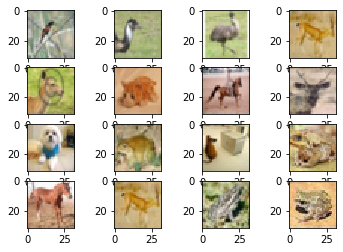

In [54]:


fig, axs = plt.subplots(4, 4)
axs = axs.ravel()
for k in range(16):
    axs[k].imshow(image_set[indexes[k]].astype('uint8'))
    cv2.imwrite('./New-storage/Im_' + str(k) + '.png', image_set[indexes[k]].astype('uint8'))
plt.show()

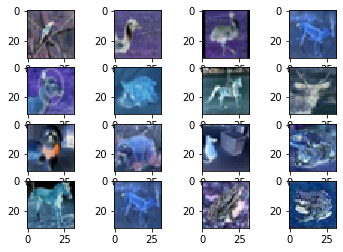

In [55]:
compressed_set, min, max = mmdf.Encoder(image_set)
fig, axs = plt.subplots(4, 4)
axs = axs.ravel()
for k in range(16):
    axs[k].imshow(compressed_set[indexes[k]].astype('uint8'))
    cv2.imwrite('./New-storage/Compressed_' + str(k) + '.png', compressed_set[indexes[k]].astype('uint8'))
plt.show()

In [58]:
np.save("./New-storage/im.npy", image_set[indexes].astype('uint8'))
np.save("./New-storage/com.npy", compressed_set[indexes].astype('uint8'))

In [6]:
for name, cluster in clusters.items():
    print(name)
    for value in np.unique(cluster):
        image_set = X[cluster == value]
        compressed_set, min, max = mmdf.Encoder(image_set)

        print(min.max(), max.min())
        # os.chdir(path)
        # path = ".\Dataset\Compressed\mmdf_png\ " + name  + "\ "

        # for i in range(compressed_set.shape[0]):
        #     cv2.imwrite(path + "cluster" + str(value) + 'im' + str(i) + ".png", compressed_set[i].reshape((32,32,-1)))
        
        # cv2.imwrite(path + "min" + str(value) + ".png", min.reshape((32,32,-1)))
        # cv2.imwrite(path + "max" + str(value) + ".png", max.reshape((32,32,-1)))


KMeans10
117.0 227.0
75.0 199.0
29.0 189.0
24.0 206.0
59.0 225.0
29.0 139.0
30.0 132.0
66.0 181.0
37.0 164.0
69.0 222.0
128.0 196.0
109.0 170.0
11.0 180.0
79.0 182.0
155.0 185.0
136.0 187.0
36.0 181.0
84.0 195.0
81.0 207.0
24.0 168.0
60.0 147.0
17.0 130.0
34.0 193.0
117.0 183.0
72.0 169.0
146.0 232.0
34.0 188.0
131.0 210.0
44.0 204.0
89.0 214.0
39.0 209.0
37.0 191.0
161.0 213.0
23.0 193.0
70.0 189.0
102.0 217.0
58.0 200.0
23.0 173.0
23.0 150.0
65.0 175.0
150.0 216.0
63.0 204.0
36.0 233.0
50.0 174.0
57.0 164.0
4.0 110.0
136.0 255.0
139.0 181.0
64.0 191.0
47.0 193.0
134.0 248.0
62.0 164.0
46.0 157.0
42.0 195.0
79.0 152.0
40.0 149.0
0.0 105.0
63.0 209.0
28.0 156.0
50.0 197.0
63.0 208.0
26.0 171.0
165.0 236.0
41.0 161.0
19.0 157.0
102.0 196.0
110.0 231.0
87.0 181.0
60.0 244.0
88.0 205.0
128.0 194.0
29.0 162.0
153.0 205.0
20.0 189.0
63.0 182.0
42.0 196.0
51.0 191.0
73.0 195.0
133.0 194.0
65.0 192.0
4.0 171.0
55.0 175.0
28.0 145.0
139.0 213.0
89.0 210.0
38.0 175.0
25.0 151.0
45.0 207.0
53.0 

KeyboardInterrupt: 

#### Get size of compressed images

In [38]:
for name in clusters:
    print(name)

KMeans40
KMeans50
KMeans60
KMeans70
KMeans80
KMeans90


In [39]:
for name in clusters:
    path = ".\Dataset\Compressed\mmdf_png\ " + name  + "\ "

    size = 0
    for f in glob.glob(path + "*.png"):
        size = size + os.path.getsize(f)
    
    print(size)
    np.save("./Saved_datas/mmdf_" + name + "_png_size.npy", size)

151919381
152633064
153323341
154012987
154616893
155083185


## Min Max Predictive

In [5]:
import min_max_predictive as mmp

####  Prepare the directories for saving the compressed images

In [12]:
for name, cluster in clusters.items():
    print(name)
    for value in np.unique(cluster):

        path = ".\Dataset\Compressed\mmp_png\ " + name  + "\ "

        if os.path.exists(path):
            # os.rmdir(path)
            files = glob.glob(path + '*')
            for f in files:
                os.remove(f)
        else:
            os.mkdir(path)

KMeans10
KMeans20
KMeans30
KMeans40
KMeans50
KMeans60
KMeans70
KMeans80
KMeans90


In [13]:
for name, cluster in clusters.items():
    print(name)
    for value in np.unique(cluster):
        image_set = X[cluster == value]
        compressed_set, level, min, max = mmp.Encoder(image_set)

        # os.chdir(path)
        path = ".\Dataset\Compressed\mmp_png\ " + name  + "\ "

        for i in range(compressed_set.shape[0]):
            cv2.imwrite(path + "cluster" + str(value) + 'im' + str(i) + ".png", compressed_set[i])
        
        np.save(path + "level" + str(value) + ".npy", level)
        cv2.imwrite(path + "min" + str(value) + ".png", min)
        cv2.imwrite(path + "max" + str(value) + ".png", max)


KMeans10
KMeans20
KMeans30
KMeans40
KMeans50
KMeans60
KMeans70
KMeans80
KMeans90


#### Get size of compressed images

In [14]:
for name in clusters:
    path = ".\Dataset\Compressed\mmp_png\ " + name  + "\ "

    size = 0
    for f in glob.glob(path + "*.png"):
        size = size + os.path.getsize(f)
    for f in glob.glob(path + "*.npy"):
        size = size + os.path.getsize(f)
    
    print(size)
    np.save("./Saved_datas/mmdf_" + name + "_png_size.npy", size)

334790159
332244375
332712277
333148966
333435277
333821840
334086773
334339200
334568023


## Combine with Delta Encoding

In [16]:
import delta

####  Prepare the directories for saving the compressed images

In [22]:
for name, cluster in clusters.items():
    print(name)
    for value in np.unique(cluster):

        path = ".\Dataset\Compressed\delta_mmdf_png\ " + name  + "\ "

        if os.path.exists(path):
            # os.rmdir(path)
            files = glob.glob(path + '*')
            for f in files:
                os.remove(f)
        else:
            os.mkdir(path)

KMeans10
KMeans20
KMeans30
KMeans40
KMeans50
KMeans60
KMeans70
KMeans80
KMeans90


In [23]:
for name, cluster in clusters.items():
    print(name)
    for value in np.unique(cluster):
        image_set = X[cluster == value]
        image_set = delta.Delta_Encoder(image_set)
        compressed_set, min, max = mmdf.Encoder(image_set)
        

        # os.chdir(path)
        path = ".\Dataset\Compressed\delta_mmdf_png\ " + name  + "\ "

        for i in range(compressed_set.shape[0]):
            cv2.imwrite(path + "cluster" + str(value) + 'im' + str(i) + ".png", compressed_set[i])
        
        cv2.imwrite(path + "min" + str(value) + ".png", min)
        cv2.imwrite(path + "max" + str(value) + ".png", max)


KMeans10
KMeans20
KMeans30
KMeans40
KMeans50
KMeans60
KMeans70
KMeans80
KMeans90


#### Get size of compressed images

In [24]:
for name in clusters:
    path = ".\Dataset\Compressed\delta_mmdf_png\ " + name  + "\ "

    size = 0
    for f in glob.glob(path + "*.png"):
        size = size + os.path.getsize(f)
    
    print(size)
    np.save("./Saved_datas/delta_mmdf" + name + "_png_size.npy", size)

166271795
162732042
163828303
164291782
164934439
165173088
165587916
165915535
166092224


## Delta and PNG

####  Prepare the directories for saving the compressed images

In [29]:

path_png = ".\Dataset\Compressed\delta_png\ "

if os.path.exists(path_png):
    # os.rmdir(path_png)
    files = glob.glob(path_png + '*')
    for f in files:
        os.remove(f)
else:
    os.mkdir(path_png)

# os.chdir(path_png)

X_delta = delta.Delta_Encoder(X)

for i in range(X.shape[0]):
    cv2.imwrite(path_png + str(i) + ".png", X_delta[i,:,:,:])


#### Get size of compressed images

In [30]:

path = ".\Dataset\Compressed\delta_png\ "

size = 0
for f in glob.glob(path + "*.png"):
    size = size + os.path.getsize(f)

print(size)
np.save("./Saved_datas/delta_png_size.npy", size)

95154655
